# Kaggle May 2021 monthly challenge
This notebook was built to explore the Kaggle May 2021 monthly challenge.

## Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

## The rundown
There are 50 features - we don't know exactly what they represent. They are used to predict the row belonging to one of four classes. We need to predict the likelihood of belonging to each.

There are 100,000 rows in the training dataset and 50,000 in the test set.

## Load the data
We'll load training data and examine the class/feature relationships. Then we'll load the test data, and glue the two together to examine them. We'll also get rid of the 'id' column, since it isn't necessary.

In [20]:
train_all = pd.read_csv('~/Data/Kaggle/May2021/train.csv') 
test_X = pd.read_csv('~/Data/Kaggle/May2021/test.csv')

In [21]:
train_y = train_all['target']

In [22]:
train_X = train_all.drop(['target', 'id'], axis=1)
test_X = test_X.drop('id', axis=1)                        

In [23]:
data_X = pd.concat([train_X, test_X])

## Investigate the data

In [24]:
# Are there any missing values for features?
test_X.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
feature_0,50000.000000,0.254620,0.910607,0.000000,0.000000,0.000000,0.000000,10.000000
feature_1,50000.000000,0.443480,2.004536,0.000000,0.000000,0.000000,0.000000,31.000000
feature_2,50000.000000,0.116720,0.524807,0.000000,0.000000,0.000000,0.000000,6.000000
feature_3,50000.000000,0.584440,1.814083,0.000000,0.000000,0.000000,0.000000,25.000000
feature_4,50000.000000,0.612640,2.819580,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,50000.000000,0.161500,0.605760,0.000000,0.000000,0.000000,0.000000,9.000000
feature_6,50000.000000,0.746000,2.352495,0.000000,0.000000,0.000000,0.000000,25.000000
feature_7,50000.000000,1.238040,2.728055,0.000000,0.000000,0.000000,1.000000,29.000000
feature_8,50000.000000,0.886440,3.364154,0.000000,0.000000,0.000000,0.000000,35.000000
feature_9,50000.000000,0.941920,1.913358,0.000000,0.000000,0.000000,1.000000,16.000000


In [25]:
train_X.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
feature_0,100000.000000,0.257830,0.929033,0.000000,0.000000,0.000000,0.000000,10.000000
feature_1,100000.000000,0.431720,1.977862,0.000000,0.000000,0.000000,0.000000,31.000000
feature_2,100000.000000,0.114130,0.519584,0.000000,0.000000,0.000000,0.000000,6.000000
feature_3,100000.000000,0.590550,1.844558,0.000000,0.000000,0.000000,0.000000,26.000000
feature_4,100000.000000,0.599770,2.785531,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,100000.000000,0.160820,0.601149,0.000000,0.000000,0.000000,0.000000,10.000000
feature_6,100000.000000,0.731490,2.343465,0.000000,0.000000,0.000000,0.000000,27.000000
feature_7,100000.000000,1.228920,2.692732,0.000000,0.000000,0.000000,1.000000,31.000000
feature_8,100000.000000,0.903350,3.415258,0.000000,0.000000,0.000000,0.000000,39.000000
feature_9,100000.000000,0.940120,1.904172,0.000000,0.000000,0.000000,1.000000,17.000000


In [26]:
data_X.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
feature_0,150000.000000,0.256760,0.922930,0.000000,0.000000,0.000000,0.000000,10.000000
feature_1,150000.000000,0.435640,1.986794,0.000000,0.000000,0.000000,0.000000,31.000000
feature_2,150000.000000,0.114993,0.521330,0.000000,0.000000,0.000000,0.000000,6.000000
feature_3,150000.000000,0.588513,1.834452,0.000000,0.000000,0.000000,0.000000,26.000000
feature_4,150000.000000,0.604060,2.796924,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,150000.000000,0.161047,0.602688,0.000000,0.000000,0.000000,0.000000,10.000000
feature_6,150000.000000,0.736327,2.346481,0.000000,0.000000,0.000000,0.000000,27.000000
feature_7,150000.000000,1.231960,2.704552,0.000000,0.000000,0.000000,1.000000,31.000000
feature_8,150000.000000,0.897713,3.398307,0.000000,0.000000,0.000000,0.000000,39.000000
feature_9,150000.000000,0.940720,1.907233,0.000000,0.000000,0.000000,1.000000,17.000000


From the above, it looks like the features are all heavily skewed toward smaller values. That checks out from the data overview given in the challenge docs. It looks like most of the entries in each feature are 0. Feature 42 had a minimum value of 0 in the training set and -2 in the test set, so we'll see how weird that turns out to be. Otherwise, the summaries of the training and test sets did not reveal any material difference in distribution. However, it does look like there's some differences in the range of some features between the training and test sets, so if we do scaling we might want to combine them first.

In [10]:
# Any missing values?
missing_vals = data_X.isnull().sum()
missing_vals.sum()
# Nope

0

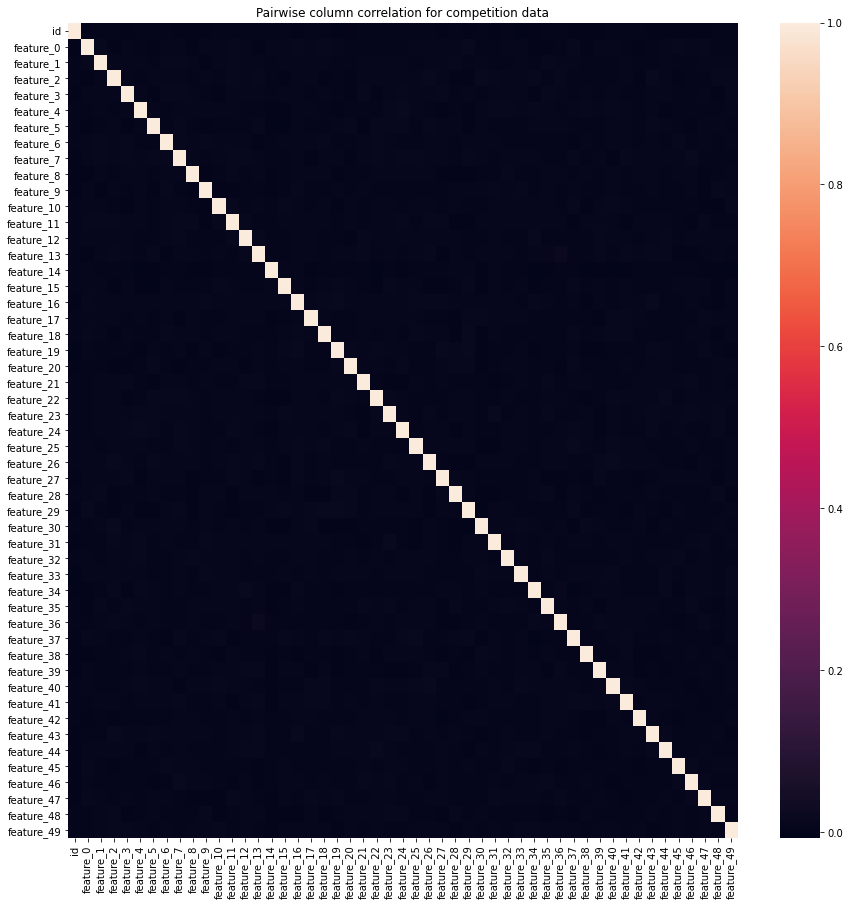

In [17]:
### Check cross-correlation
datacorr = data_X.corr()
plt.figure(figsize=(15,15))
plt.title("Pairwise column correlation for competition data")
sns.heatmap(datacorr)
plt.show()

It appears that no two columns are correlated. Running `data_X.dtypes` shows that the data are all integers. I was going to look up and research how to do a batch KDE plot of each column, but other contestants have done that, so I shamelessly stole it.

In [27]:
## NEXT STEPS
# KDE plots of features
# Plots of class prediction by feature
# Clustering algo